In [1]:
import warnings
warnings.filterwarnings('ignore')

# Regression Model

This notebook includes our final regression model for the nightly price of an AirBnB in Washington DC. We will then evaluate that model using cross-validation and learning curves and finally make three predictions.

Throughout this notebook, we will be comparing this model to what we refer to as the "null model" which is the model dicussesed in `baseline.ipynb`.

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import random as py_random
import numpy.random as np_random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import duckdb

sns.set(style="whitegrid")

## Data Loading

We are first going to load in all of the tables and views in our data warehouse into Pandas dataframes. We don't use all tables or views but we include information on each of the variables in the dataset for completion.

In [6]:
con = duckdb.connect(database='ps6.duckdb', read_only=True)

### Load Views into Data Frames

#### All Listings
This view includes every row brought in from the detailed listings.csv from the Washington D.C. AirBnB data set. Some listings may be repeated if they are included in more than one quarter's listings data.

In [7]:
# Loading dataset
# connect to database

# read the result of an arbitrary SQL query to a Pandas DataFrame
all_listings = con.execute("SELECT * from all_listings").df()

In [8]:
all_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28076 entries, 0 to 28075
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            28076 non-null  int64         
 1   listing_url                                   28076 non-null  object        
 2   scrape_id                                     28076 non-null  int64         
 3   last_scraped                                  28076 non-null  datetime64[ns]
 4   name                                          28074 non-null  object        
 5   description                                   27666 non-null  object        
 6   neighborhood_overview                         18547 non-null  object        
 7   picture_url                                   28076 non-null  object        
 8   host_id                                       28076 non-null  int3

In [9]:
latest_listings = con.execute("SELECT * from latest_listings").df()

In [10]:
latest_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10560 entries, 0 to 10559
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            10560 non-null  int64         
 1   listing_url                                   10560 non-null  object        
 2   scrape_id                                     10560 non-null  int64         
 3   last_scraped                                  10560 non-null  datetime64[ns]
 4   name                                          10559 non-null  object        
 5   description                                   10416 non-null  object        
 6   neighborhood_overview                         6559 non-null   object        
 7   picture_url                                   10560 non-null  object        
 8   host_id                                       10560 non-null  int3

In [11]:
neighborhoods = con.execute("SELECT * from neighborhoods").df()

In [12]:
neighborhoods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   neighbourhood_group  0 non-null      object
 1   neighbourhood        39 non-null     object
 2   type_outer           39 non-null     object
 3   feature_type         39 non-null     object
 4   geometry_type        39 non-null     object
 5   coordinates          39 non-null     object
dtypes: object(6)
memory usage: 2.0+ KB


In [13]:
reviews = con.execute("SELECT * from reviews").df()

In [14]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321209 entries, 0 to 321208
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   listing_id     321209 non-null  int64         
 1   id             321209 non-null  int64         
 2   date           321209 non-null  datetime64[ns]
 3   reviewer_id    321209 non-null  int32         
 4   reviewer_name  321208 non-null  object        
 5   comments       321127 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(2), object(2)
memory usage: 13.5+ MB


In [15]:
calendar = con.execute("SELECT * from calendar").df()

In [16]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10245531 entries, 0 to 10245530
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           float64       
 4   adjusted_price  float64       
 5   minimum_nights  float64       
 6   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 547.2+ MB


## Secondary data source
`crimes` is the secondary dataset that our group chose to enrich our AirBnB data. We were curious about how data like the number of crimes in the nighborhood of a listing might affect the price of that listing. 

In [17]:
crimes = con.execute("SELECT * from crimes").df()

In [18]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27611 entries, 0 to 27610
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   column00              27611 non-null  int32         
 1   NEIGHBORHOOD_CLUSTER  27609 non-null  object        
 2   offensegroup          27611 non-null  object        
 3   LONGITUDE             27611 non-null  float64       
 4   END_DATE              25411 non-null  object        
 5   offense-text          27611 non-null  object        
 6   SHIFT                 27611 non-null  object        
 7   offensekey            27611 non-null  object        
 8   START_DATE            27602 non-null  datetime64[ns]
 9   OFFENSE               27611 non-null  object        
 10  METHOD                27611 non-null  object        
 11  LATITUDE              27611 non-null  float64       
 12  NEIGHBORHOOD_NAME     27611 non-null  object        
dtypes: datetime64[ns

In [19]:
neighborhood_crimes = con.execute("SELECT * from neighborhood_crimes").df()

In [20]:
neighborhood_crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   NEIGHBORHOOD_NAME  46 non-null     object
 1   homicides          46 non-null     int64 
 2   robberies          46 non-null     int64 
 3   assaults           46 non-null     int64 
 4   theft_from_auto    46 non-null     int64 
 5   other_thefts       46 non-null     int64 
 6   vehicle_theft      46 non-null     int64 
 7   burglaries         46 non-null     int64 
 8   sex_abuses         46 non-null     int64 
 9   arsons             46 non-null     int64 
 10  violent_crimes     46 non-null     int64 
 11  property_crimes    46 non-null     int64 
 12  total_crimes       46 non-null     int64 
dtypes: int64(12), object(1)
memory usage: 4.8+ KB


## Full Latest Listings View
The full_latest_listings view includes the latest listings data, with one row per listing, and aggregate crime data.

This is a convenient data set to use for modeling.

In [21]:
full_latest_listings = con.execute("SELECT * from full_latest_listings").df()

In [22]:
full_latest_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10560 entries, 0 to 10559
Data columns (total 87 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            10560 non-null  int64         
 1   listing_url                                   10560 non-null  object        
 2   scrape_id                                     10560 non-null  int64         
 3   last_scraped                                  10560 non-null  datetime64[ns]
 4   name                                          10559 non-null  object        
 5   description                                   10416 non-null  object        
 6   neighborhood_overview                         6559 non-null   object        
 7   picture_url                                   10560 non-null  object        
 8   host_id                                       10560 non-null  int3

The variable we found in our EDA that had the highest correlation/predictive value for `price` was `violent_crimes` which is the sum of violent crimes that happened per neighborhood. For reference, we'll list the number of violent crimes per neighborhood.

In [23]:
full_latest_listings[['NEIGHBORHOOD_NAME','violent_crimes']].drop_duplicates().sort_values('NEIGHBORHOOD_NAME', ignore_index=True)

NEIGHBORHOOD_NAME  violent_crimes
0                Brightwood Park, Crestwood, Petworth             156
1                       Brookland, Brentwood, Langdon             124
2                          Capitol Hill, Lincoln Park             121
3     Capitol View, Marshall Heights, Benning Heights             176
4      Cathedral Heights, McLean Gardens, Glover Park              12
5   Cleveland Park, Woodley Park, Massachusetts Av...              14
6   Colonial Village, Shepherd Park, North Portal ...              13
7   Columbia Heights, Mt. Pleasant, Pleasant Plain...             226
8    Congress Heights, Bellevue, Washington Highlands             369
9   Deanwood, Burrville, Grant Park, Lincoln Heigh...             167
10                           Douglas, Shipley Terrace             132
11  Downtown, Chinatown, Penn Quarters, Mount Vern...             149
12         Dupont Circle, Connecticut Avenue/K Street             109
13                       Eastland Gardens, Kenilworth              14
14  Edgewood, Bloomingdale, Truxton Circle, Eckington             200
15  Fairfax Village, Naylor Gardens, Hillcrest, Su...              59
16  Friendship Heights, American University Park, ...              23
17                    Georgetown, Burleith/Hillandale              18
18              Hawthorne, Barnaby Woods, Chevy Chase               5
19                                 Historic Anacostia              65
20     Howard University, Le Droit Park, Cardozo/Shaw             172
21     Ivy City, Arboretum, Trinidad, Carver Langston             254
22     Kalorama Heights, Adams Morgan, Lanier Heights              66
23  Lamont Riggs, Queens Chapel, Fort Totten, Plea...              59
24               Mayfair, Hillbrook, Mahaning Heights             102
25                          Near Southeast, Navy Yard              54
26       North Cleveland Park, Forest Hills, Van Ness              24
27  North Michigan Park, Michigan Park, University...              38
28      River Terrace, Benning, Greenway, Dupont Park             156
29                                 Shaw, Logan Circle             105
30                  Sheridan, Barry Farm, Buena Vista              77
31  Southwest Employment Area, Southwest/Waterfron...              70
32  Spring Valley, Palisades, Wesley Heights, Foxh...               2
33                     Takoma, Brightwood, Manor Park              71
34  Twining, Fairlawn, Randle Highlands, Penn Bran...             199
35          Union Station, Stanton Park, Kingman Park             251
36                        West End, Foggy Bottom, GWU              20
37  Woodland/Fort Stanton, Garfield Heights, Knox ...              91
38                   Woodridge, Fort Lincoln, Gateway              59

## Model Building

We are now going to start building our regression model. We will start by insantiating some functions that will help us evaluate our model and its constituent variables. 

In [25]:
# Code from Lab 10 Solution
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

In [26]:
import models

In [27]:
# Code from Lab 10 Solution
def plot_residuals(result, df, variables):
    height = (len(variables) // 3) * 6 
    figure = plt.figure(figsize=(20,height))

    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(df[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()
    
    return residuals

Now we need to choose the variables that will constitute our regression model. The `full_latest_listings` contains many of the necessary variables for our regression - all pulled together from other tables. 

Notably, `full_latest_listings` is also the *latest* listings which are only AirBnB listings from the last quarter and not from the earlier three quarters. We chose to build our model off of latest listings as opposed to the all listings because:
1. We don't expect price of duplicate AirBnBs to change meaningfully across the 4 quarters meaning:
2. Including duplicate data would amount to having many of the same data points over and over again which can lead to **overfitting**. Overfitting hurts our model's generalizability meaning that we won't have high accuracy on out-of-training-data predictions.

We chose the *latest* quarter (as opposed to quarter 1, 2, or 3) for recency.

In [28]:
full_latest_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10560 entries, 0 to 10559
Data columns (total 87 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            10560 non-null  int64         
 1   listing_url                                   10560 non-null  object        
 2   scrape_id                                     10560 non-null  int64         
 3   last_scraped                                  10560 non-null  datetime64[ns]
 4   name                                          10559 non-null  object        
 5   description                                   10416 non-null  object        
 6   neighborhood_overview                         6559 non-null   object        
 7   picture_url                                   10560 non-null  object        
 8   host_id                                       10560 non-null  int3

Our team used
1. Domain knowledge
2. EDA
3. Trial and error of alternative regression models

To come up with the following list of variables for our final regression model:
* `host_listings_count`
* `latitude`
* `longitude"`
* `room_type`
* `accommodates`
* `bedrooms`
* `beds`
* `minimum_nights`
* `maximum_nights`
* `number_of_reviews_ltm`
* `number_of_reviews`
* `review_scores_rating`
* `review_scores_accuracy`
* `review_scores_cleanliness`
* `review_scores_checkin`
* `review_scores_communication`
* `review_scores_location`
* `review_scores_value`
* `reviews_per_month`
* `violent_crimes`
* `host_identity_verified`

Let's filter our latest listings dataframe to include only rows that have non-null/non-NaN values for these variables.

In [29]:
df = full_latest_listings[full_latest_listings[["host_listings_count",
                                               "latitude",
                                               "longitude", 
                                               "room_type",
                                               "accommodates",
                                               "bedrooms",
                                               "beds",
                                               "minimum_nights",
                                               "maximum_nights",
                                               "number_of_reviews_ltm",
                                               "number_of_reviews",
                                               "review_scores_rating",
                                               "review_scores_accuracy",
                                               "review_scores_cleanliness",
                                               "review_scores_checkin",
                                               "review_scores_communication",
                                               "review_scores_location",
                                               "review_scores_value",
                                               "reviews_per_month",
                                               "violent_crimes",
                                               "host_identity_verified"]].notnull().all(1)]
df = df[["price",
                "host_listings_count",
                "latitude",
                "longitude",
                "room_type",
                "accommodates",
                "bedrooms",
                "beds",
                "minimum_nights",
                "maximum_nights",
                "number_of_reviews_ltm",
                "number_of_reviews",
                "review_scores_rating",
                "review_scores_accuracy",
                "review_scores_cleanliness",
                "review_scores_checkin",
                "review_scores_communication",
                "review_scores_location",
                "review_scores_value",
                "reviews_per_month",
                "violent_crimes",
                "host_identity_verified"]].copy()

We also know from our EDA and queries that `price` has a handful of extreme outliers. The above filtering might have already eliminated those outliers. Let's remove all listings with a nightly price greater than \$1000 and see the percentage of listings that are removed in the process.

We chose 1000 because we found that it was reasonably far beyond the 25th, 50th, and 75th percentile to categorize it as an outlier while not being too large so as to hurt the performance of our model for the wide majority of prices which were between 50 and 250. We expect that if we were to field this regression model as a product, we could reasonably expect most users wanting to predict the price of their AirBnB to be satisfied with a price cap at 1000.

In [30]:
df = df[df.price <= 1000]

This removed 36 / 6751 = 0.5% of entries which is a tolerable amount. Our EDA of `price` also supports this decision because the mean `price` before filtering was: 201 USD and the 25th, 50th, and the 75th percentile were 85, 127 and 201, respectively. 

Next, we need to convert all cateogorical variables into one-hot-encodings in order to be useable in the regression.

In [32]:
# Encode categorical variables into one-hot-encodings
df = pd.concat([df, pd.get_dummies(df["room_type"], prefix='room_type')], axis=1)
df = pd.concat([df, pd.get_dummies(df["host_identity_verified"], prefix='host_identity_verified')], axis=1)

The new column names created here might have resulted in spaces in the column names so lets fix that:

In [33]:
df.columns = df.columns.str.replace(', ','_')
df.columns = df.columns.str.replace(' ','_')
df.columns = df.columns.str.replace('\._','_')
df.columns = df.columns.str.replace('/|-','')

We are going to be modeling `price` so it is important to understand the distribution of that variable. We know from our EDA and the creation of the null model that `price` has a skewed distribution. It would be beneficial to transform `price` into `log-price` so that the distribution approached a symmetric, Normal distribution.

In [34]:
df["log_price"] = df["price"].apply(np.log)

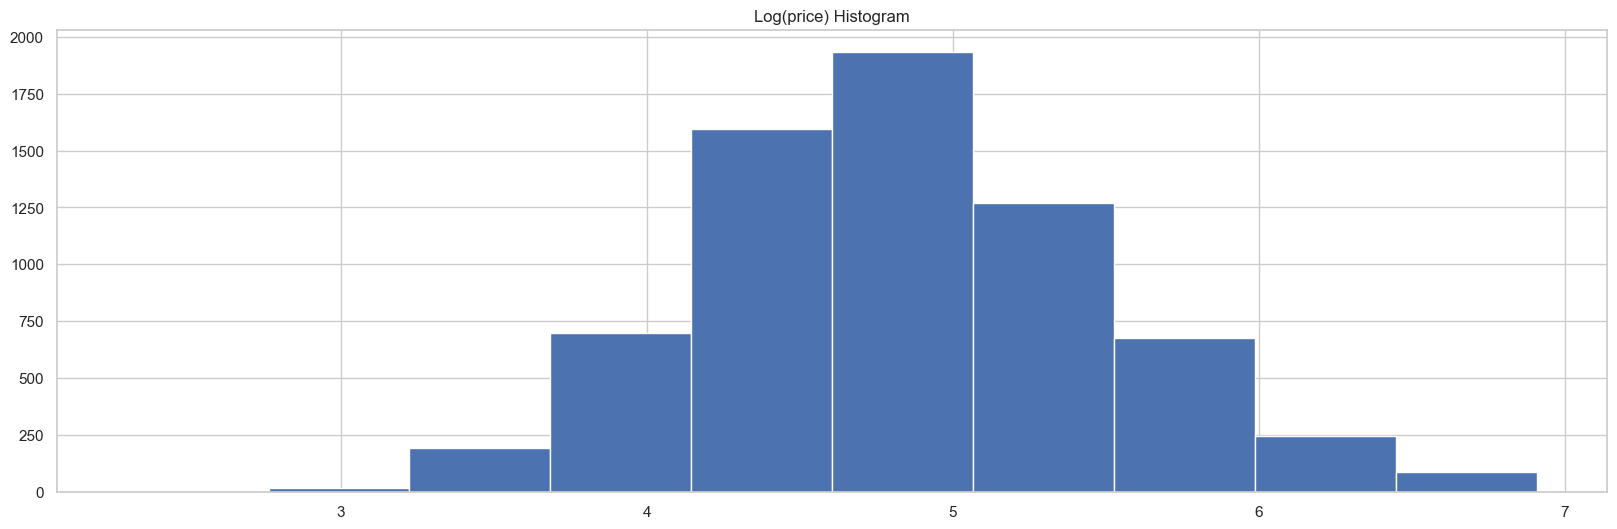

In [114]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.hist(df.log_price)
axes.set_title("Log(price) Histogram")
plt.show()
plt.close()

This distribution looks more symmetric. We will be predicting `log_price` with our model.

We no longer need the "object" type variables as they have been replaced by numerical one-hot encodings:

In [36]:
df = df.select_dtypes(exclude=['object'])

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6715 entries, 0 to 10549
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   price                         6715 non-null   float64
 1   host_listings_count           6715 non-null   float64
 2   latitude                      6715 non-null   float64
 3   longitude                     6715 non-null   float64
 4   accommodates                  6715 non-null   int32  
 5   bedrooms                      6715 non-null   float64
 6   beds                          6715 non-null   float64
 7   minimum_nights                6715 non-null   int32  
 8   maximum_nights                6715 non-null   int32  
 9   number_of_reviews_ltm         6715 non-null   int32  
 10  number_of_reviews             6715 non-null   int32  
 11  review_scores_rating          6715 non-null   float64
 12  review_scores_accuracy        6715 non-null   float64
 13  re

When creating the actual model, we must remove one one-hot-encoded categorical variables so that the y-intercept of the model is interpretable:

In [52]:
model_variables = ['host_listings_count',
                     'latitude',
                     'longitude',
                     'accommodates',
                     'bedrooms',
                     'beds',
                     'minimum_nights',
                     'maximum_nights',
                     'number_of_reviews_ltm',
                     'number_of_reviews',
                     'review_scores_rating',
                     'review_scores_accuracy',
                     'review_scores_cleanliness',
                     'review_scores_checkin',
                     'review_scores_communication',
                     'review_scores_location',
                     'review_scores_value',
                     'reviews_per_month',
                     'violent_crimes',
                     'room_type_Entire_homeapt',
                     'room_type_Hotel_room',
                     'room_type_Private_room',
#                      'room_type_Shared_room',
                     'host_identity_verified_False',
#                      'host_identity_verified_True',
                      ]

Now let's look at the correlations coefficients for each variable in or model with `log_price`.

In [39]:
correlations(df, "log_price", df.columns.values.tolist())

feature         r       rho
0                          price  0.899914  1.000000
1            host_listings_count  0.082657  0.028360
2                       latitude -0.091517 -0.133721
3                      longitude -0.149263 -0.138889
4                   accommodates  0.593653  0.622281
5                       bedrooms  0.596898  0.599590
6                           beds  0.464350  0.535848
7                 minimum_nights  0.004228  0.014154
8                 maximum_nights  0.019535  0.083456
9          number_of_reviews_ltm  0.086171  0.148961
10             number_of_reviews -0.007513  0.004874
11          review_scores_rating  0.063512  0.080738
12        review_scores_accuracy  0.035579  0.055293
13     review_scores_cleanliness  0.103900  0.113144
14         review_scores_checkin  0.001992  0.029995
15   review_scores_communication -0.007127  0.019137
16        review_scores_location  0.138357  0.203495
17           review_scores_value -0.006496 -0.024706
18             reviews_per_month  0.059912  0.094734
19                violent_crimes -0.074163 -0.061904
20      room_type_Entire_homeapt  0.506162  0.523631
21          room_type_Hotel_room -0.090992 -0.063876
22        room_type_Private_room -0.456913 -0.482954
23         room_type_Shared_room -0.181160 -0.163918
24  host_identity_verified_False -0.013812 -0.021373
25   host_identity_verified_True  0.013812  0.021373
26                     log_price  1.000000  1.000000

And here is the correlations between all the model variabels and regular `price`.

In [40]:
correlations(df, "price", df.columns.values.tolist())

feature         r       rho
0                          price  1.000000  1.000000
1            host_listings_count  0.056107  0.028360
2                       latitude -0.082851 -0.133721
3                      longitude -0.117552 -0.138889
4                   accommodates  0.573274  0.622281
5                       bedrooms  0.615569  0.599590
6                           beds  0.478420  0.535848
7                 minimum_nights  0.020790  0.014154
8                 maximum_nights  0.018611  0.083456
9          number_of_reviews_ltm  0.020588  0.148961
10             number_of_reviews -0.053327  0.004874
11          review_scores_rating  0.040370  0.080738
12        review_scores_accuracy  0.008794  0.055293
13     review_scores_cleanliness  0.059820  0.113144
14         review_scores_checkin -0.011653  0.029995
15   review_scores_communication -0.018098  0.019137
16        review_scores_location  0.091118  0.203495
17           review_scores_value -0.027861 -0.024706
18             reviews_per_month -0.003883  0.094734
19                violent_crimes -0.073404 -0.061904
20      room_type_Entire_homeapt  0.327073  0.523631
21          room_type_Hotel_room -0.036810 -0.063876
22        room_type_Private_room -0.302324 -0.482954
23         room_type_Shared_room -0.101439 -0.163918
24  host_identity_verified_False -0.008370 -0.021373
25   host_identity_verified_True  0.008370  0.021373
26                     log_price  0.899914  1.000000

Note that `rho` or the Spearman coefficient does not change between `log_price` and `price` whereas `r` or  the Pearson's correlation coefficient does change. This is because Pearson's measures the *linear* dependence between the variable which changes when we apply a transformation like log to one of the variables.

## Final Regression Model

In [41]:
model_string = "log_price ~ " + ' + '.join(model_variables)

In [53]:
result = models.bootstrap_linear_regression(model_string, data=df)
models.describe_bootstrap_lr(result)

We have an $R^2$ of 0.56 which is fair performance for a real-world model. The $\sigma$ value is 0.43 in **log space**. That means that we can get a 95% CI on the mean price of:

In [124]:
(np.exp(np.log(171.046379) - (1.96 * 0.43)), np.exp(np.log(171.046379) + (1.96 * 0.43)))

(73.63605194038358, 397.31711570710326)

Where the mean of 171 comes from the mean price for latest listings below 1000. 

Compared to the null model, which had a standard deviation (not in log space) of **144.426415**, the interval for the mean would be: 

In [125]:
(171.046379 - 1.96*144.426415, 171.046379 + 1.96*144.426415)

(-112.0293944, 454.1221524)

**Comparing these two confidence intervals, we can say that our model yields tighter, more sensical confidence intervals than the null model.**

The values of the coefficients hold valuable information as well:

* latitude and longitude have a negative correlation with price. This means that as listings increase in latitude and longitude (as listings become more and more *northeast* within DC), their price descreases. This tracks with our domain knowledge and neighborhood based EDA.
* Other variables with notable negative correlations include: beds, review_scores_checkin, review_scores_communication, review_scores_value, and hotel type rooms. This seems to indicate that cheaper listings tended to have higher ratings in a few of the review categories.
* accomodates, bedrooms, review_score_rating, review_score_cleanliness, review_score_location, home/apartment room types, and private rooms all had postive coefficients which aligns with our domain knowledge and EDA.
* Many of the variables appear to have either 0 or possibly 0 (95% BCI contains 0) coefficients with `log_price`.
* The y-intercept coefficient isn't particularly interesting because we don't have any houses that accomodate zero people or exist at a (0,0) lat/lon.

Let's now look at the residual plots for each of the variables in our model. We hope to see a symmetric distribution centered at 0 with a denser collection of points closer to the 0 line than further away. We also want to see a uniform distribution across the x-axis a.k.a. no heteroskedacity in the residuals.

In [54]:
residuals = plot_residuals(result, df, model_variables)

Each of these plots looks in line with the desired distribution of residual points.

## Cross-Validation

Cross-validation allows us to test our model's generalizability by seeing it's performance on "new data" by simulating new data being scrapped from training data. 

First, we're going define some functions to calculate the cross validation.

In [43]:
# Code from Lab 11 Solution
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

This next function does the actual cross validation:

In [44]:
# Code from Lab 11 Solution
def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

Let's run `cross_validation` on our model and data:

In [45]:
import random
import patsy

In [55]:
cv_result = cross_validation(models.linear_regression, model_string, df, lambda r: (r["sigma"], r["r_squared"]))

Using cross-validation, we can get a 95% CI for both $R^2$ and $\sigma$ when tested on *new data* so we can get an understanding of how our data would perform on new data.

In [56]:
print(r"95% CI for sigma:", stats.mstats.mquantiles([r[0] for r in cv_result], [0.025, 0.975]))

95% CI for sigma: [0.41461169 0.47870567]


In [57]:
print(r"95% CI for R^2:", stats.mstats.mquantiles([r[1] for r in cv_result], [0.025, 0.975]))

95% CI for R^2: [0.46657763 0.62646393]


We can also calculate the *mean* $\sigma$ and $R^2$ and calculate the 95% credible intervals for the *mean* values. This is useful for understanding the average performance of our model if we were to field it.

Let's start by seeing what the mean values are:

In [59]:
sigmas = [r[0] for r in cv_result]
r_squareds = [r[1] for r in cv_result]

In [60]:
print("mean sigma: ", np.mean(sigmas))
print("mean R^2: ", np.mean(r_squareds))

mean sigma:  0.4422992878849424
mean R^2:  0.5607481871543466


In [61]:
# Code from Fundamentals
def resample(data):
    n = len(data)
    return [data[ i] for i in [stats.randint.rvs(0, n - 1) for _ in range( 0, n)]]

In [62]:
bootstrap = {}
bootstrap["sigma"] = np.array([np.mean(s) for s in [resample(sigmas) for i in range( 0, 1000)]])
bootstrap["r_squared"] = np.array([np.mean(r) for r in [resample(r_squareds) for i in range( 0, 1000)]])

In [63]:
print(r"95% CI for *mean* sigma:", stats.mstats.mquantiles(bootstrap["sigma"], [0.025, 0.975]))

95% CI for *mean* sigma: [0.43830355 0.44850006]


In [64]:
print(r"95% CI for *mean* R^2:", stats.mstats.mquantiles(bootstrap["r_squared"], [0.025, 0.975]))

95% CI for *mean* R^2: [0.54619598 0.57009005]


We have obtained tigher bounds on what we think the average $\sigma$ and $R^2$ are for our model.

## Learning Curves

We now want to see how "trained" our model is: would more data help it? Is it high variance of high bias? We can accomplish this using a learning curve which calculates model fit parameters (like $\sigma$) when our model is trained on successively more data ranging from 0-100% of our training data. If we see stability in our parameter as we approach 100%, then we know more data would not help our model.

In [65]:
from collections import defaultdict

In [66]:
# Code from Lab 11 Solution
def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

In [67]:
# Code from Lab 11 Solution 
def learning_curves(algorithm, formula, data, evaluate, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: # ensures 100% is always picked.
                # the indices are already shuffled so we only need to take ever increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                result = algorithm(formula, data=train_data_chunk)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices( formula, train_data_chunk, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)
                
                # we calculate the results for the test data.
                y, X = patsy.dmatrices( formula, test_data, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
            #
        #
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results
#

In [68]:
lc_result_sigma = learning_curves(models.linear_regression, model_string, df, lambda r: r["sigma"])

In [70]:
# Code from Lab 11 Solution
def results_to_curves( curve, results):
    all_statistics = results[ curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2 * s)
        lower.append( m - 2 * s)
    return keys, lower, mean, upper

In [71]:
# Code from Lab 11 Solution
def plot_learning_curves( results, metric, zoom=False):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( xs, train_mean, color="steelblue")
    axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25, label="train")
    axes.plot( xs, test_mean, color="firebrick")
    axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25, label="test")
    axes.legend()
    axes.set_xlabel( "training set (%)")
    axes.set_ylabel( metric)
    axes.set_title("Learning Curves")

    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()
#

In [73]:
plot_learning_curves(lc_result_sigma, r"$\sigma$")

In [76]:
plot_learning_curves(lc_result_sigma, r"$\sigma$", zoom=True)

The deviation has mostly converged with some slightly sporadic changes in the value of $\sigma$ across the training set %.

# Predictions

We are now going to make 3 predictions. The three test cases are tabulated below:

In [77]:
from tabulate import tabulate

In [102]:
table = [['Variable', 'Georgetown Mansion', 'Northeast Room', 'Average Listing'],
         ['host_listings_count',1,5,1.5],
         ['latitude',38.905,38.940,38.92],
         ['longitude',-77.075,-76.975,-77],
         ['accommodates',12,2,6],
         ['bedrooms',6,1,3],
         ['beds',8,1,3],
         ['minimum_nights',3,1,4],
         ['maximum_nights',365,1125,1125],
         ['number_of_reviews_ltm',8,12,10],
         ['number_of_reviews',30,48,39],
         ['review_scores_rating',4.89,4.5,4.68],
         ['review_scores_accuracy',4.75,4.8,4.79],
         ['review_scores_cleanliness',4.71,4.75,4.73],
         ['review_scores_checkin',4.82,4.88,4.85],
         ['review_scores_communication',4.81,4.85,4.83],
         ['review_scores_location',5,4.75,4.78],
         ['review_scores_value',5,4.6,4.7],
         ['reviews_per_month',1.5,1.7,1.6],
         ['violent_crimes',4,200,50],
         ['room_type_Entire_homeapt',1,0,1],
         ['room_type_Hotel_room',0,0,0],
         ['room_type_Private_room',0,0,0],
         ['room_type_Shared_room',0,1,0],
         ['host_identity_verified_False',0,1,0],
         ['host_identity_verified_True',1,0,1]
          ]
print(tabulate(table,headers="firstrow"))

Variable                        Georgetown Mansion    Northeast Room    Average Listing
----------------------------  --------------------  ----------------  -----------------
host_listings_count                          1                 5                   1.5
latitude                                    38.905            38.94               38.92
longitude                                  -77.075           -76.975             -77
accommodates                                12                 2                   6
bedrooms                                     6                 1                   3
beds                                         8                 1                   3
minimum_nights                               3                 1                   4
maximum_nights                             365              1125                1125
number_of_reviews_ltm                        8                12                  10
number_of_reviews                           30        

In [96]:
airbnbs = [['intercept',1,1,1],
         ['host_listings_count',1,5,1.5],
         ['latitude',38.905,38.940,38.92],
         ['longitude',-77.075,-76.975,-77],
         ['accommodates',12,2,6],
         ['bedrooms',6,1,3],
         ['beds',8,1,3],
         ['minimum_nights',3,1,4],
         ['maximum_nights',365,1125,1125],
         ['number_of_reviews_ltm',8,12,10],
         ['number_of_reviews',30,48,39],
         ['review_scores_rating',4.89,4.5,4.68],
         ['review_scores_accuracy',4.75,4.8,4.79],
         ['review_scores_cleanliness',4.71,4.75,4.73],
         ['review_scores_checkin',4.82,4.88,4.85],
         ['review_scores_communication',4.81,4.85,4.83],
         ['review_scores_location',5,4.75,4.78],
         ['review_scores_value',5,4.6,4.7],
         ['reviews_per_month',1.5,1.7,1.6],
         ['violent_crimes',4,200,50],
         ['room_type_Entire_homeapt',1,0,1],
         ['room_type_Hotel_room',0,0,0],
         ['room_type_Private_room',0,0,0],
#          ['room_type_Shared_room',0,1,0],
         ['host_identity_verified_False',0,1,0],
#          ['host_identity_verified_True',1,0,1]
          ]
georgetown_mansion = [var[1] for var in airbnbs]
northeast_room = [var[2] for var in airbnbs]
average_listing = [var[3] for var in airbnbs]

### Georgetown Mansion

This example was created using the values for all variables that we know contribute positively to price. Namely, the location being in the NW area of DC near Georgetown and having a high value for accomodation, beds, and rooms. It is also listed as a home/apt room type and has favorable reviews.

In [115]:
prediction = result["model"].predict([georgetown_mansion])
np.exp(prediction)

array([[869.42274248]])

\\$869.42 per night. With an error of 0.43 in log space, this leads to error bounds of:

In [116]:
np.exp(prediction[0][0] - 1.96 * (result["sigma"])), np.exp(prediction[0][0] + 1.96 * (result["sigma"]))

(370.73155534379185, 2038.9305799253468)

Our 95% confidence interval for a listings with these characteristics is (370.73, 2038.93).

### Northeast Room

This example was created using values of all variables that we know contribute negatively to price. This listing is located in Northeast DC, accomodates only 2 people in 1 room with 1 bed, has fair or slightly below average ratings, a high violent crime rate, and is listed as a shared room as opposed to an entire home/suite.

In [118]:
prediction = result["model"].predict([northeast_room])
np.exp(prediction)

array([[36.663587]])

\\$36.66 per night. With an error of 0.43 in log space, this leads to error bounds of:

In [119]:
np.exp(prediction[0][0] - 1.96 * (result["sigma"])), np.exp(prediction[0][0] + 1.96 * (result["sigma"]))

(15.633762460181632, 85.98177279458564)

Our 95% confidence interval for a listings with these characteristics is (15.63, 85.98).

### Average Listing

This example was created using average values for all numerical variables in the model and our best attempt at averaging our the cateogorical variables. This listing has 3 bedroom and 3 beds and hosts 6 people. It has average reviews in every category.

In [121]:
prediction = result["model"].predict([average_listing])
np.exp(prediction)

array([[217.45611794]])

\\$217.46 per night. With an error of 0.43 in log space this leads to error bounds of:

In [122]:
np.exp(prediction[0][0] - 1.96 * (result["sigma"])), np.exp(prediction[0][0] + 1.96 * (result["sigma"]))

(92.72571429651462, 509.96817427440635)

Our 95% confidence interval for a listings with these characteristics is (92.73, 509.97).

In [113]:
con.close()